# Torch Transformer (Self-Attention Basic)


In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

[Pytorch_Transformer](https://pytorch.org/docs/stable/nn.html#transformer-layers)

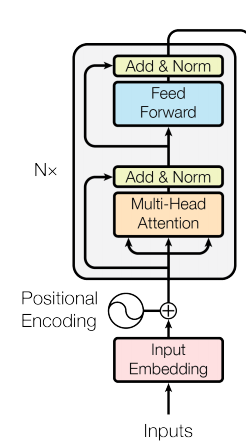

앞의 RNN 모델 (Seq2Seq)에서 Query, Key, Value 개념

~~~
Q = Query: t 시점의 Decoder의 Hidden
K = Key: 모든 시점의 Encoder Hiddens
V = Value: 모든 시점의 Encoder Hiddens
~~~

Transformer Encoder (Self-Attention)에서의 Query, Key, Value 개념
~~~
Q = Query: 모든 시점의 Encoder Hiddens
K = Key: 모든 시점의 Encoder Hiddens
V = Value: 모든 시점의 Encoder Hiddens
~~~
Self-Attention에서는 Q, K, V가 모두 같다.

Transformer Encoder의 `input`은 $d_{model}$의 차원을 가지는 단어 벡터들을 사용하여 셀프 어텐션을 수행 하는 것이 아니라 먼저 각 단어 벡터들로부터 q, k, v 벡터를 얻는 작업을 거친다. 이때 q, k, v의 차원은 $d_{model}$보다 작은 차원을 갖는데 논문에서는 $d_{model}=512$ 를 각각 64차원으로 바꾸었다.

이때 64라는 숫자는 `num_heads`로 결정이 된다. Transformer는 $d_{model}$을 `num_heads`로 나눈 값을 각 q벡터, k벡터, v벡터의 차원으로 결정한다. 논문에선은 `num_heads`가 8이다. 

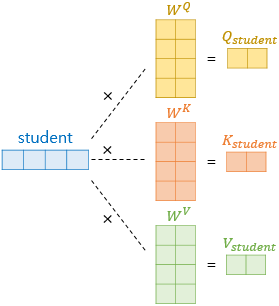

기존의 벡터로부터 더 작은 벡터는 weight matrix를 곱하면서 완성된다. 각 weight matrix의 모양은 $d_{model}\times (d_{model} / \text{num_heads})$ 이다. 이 weight matrix는 학습을 통해서 update 된다.

이렇게 얻은 Q, K, V를 이용해서 Attention Score를 Scaled dot product로 계산한다.

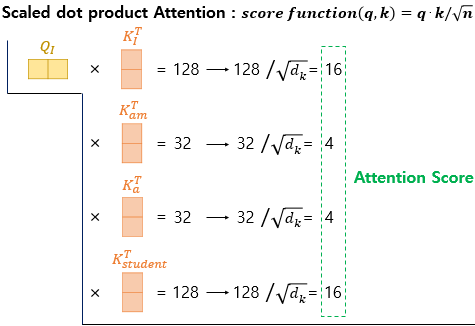

여기에서 $d_k$는 k 벡터의 차원을 나타내는 dimension size이다.
앞에서 본 것 처럼 $d_k=d_{model}/\text{num_heads}$크기를 갖는다.
따라서 $\sqrt{d_k}=8$의 값을 갖는다.

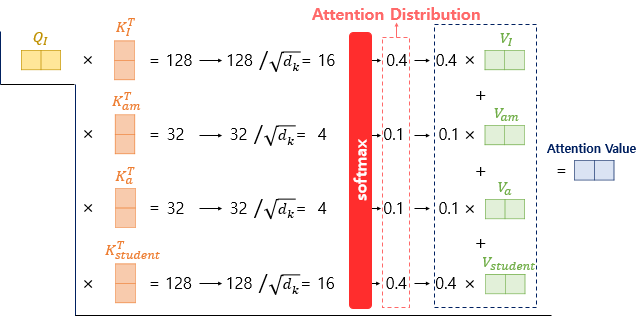

논문에서는 위의 과정을 scalable하게 계산하기 위해서 벡터 연산으로 구현 하였다.

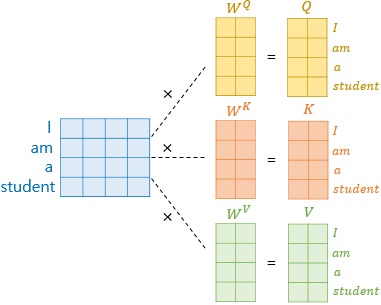

위의 과정을 통해서 나온 Q, K, V를 이용해서 attention score map (matrix)를 구한다.

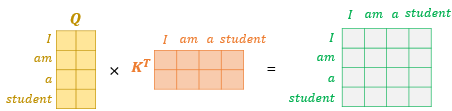

Attention Value는 다음과 같이 계산된다.

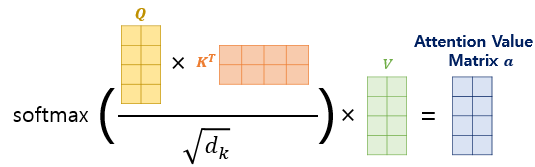

이를 식으로 나타내면

$$Attention(Q, K, V) = softmax(\frac{QK^{\top}}{\sqrt{d_k}})V$$
이 되고 결과적으로 나온 attention matrix의 크기는 $(\text{seq_len}, d_v)$가 된다.

**Multi-Head Attention**
논문을 기준으로 512 차원의 각 단어 벡터를 8개로 나누어 64차원의 Q, K, V벡터로 바꾸어서 어텐션을 수행한 것인데 `num_heads`의 의미와 $d_{model}$의 차원을 가진 벡터를 가지고 어텐션을 하지 않고 차원을 축소 시킨 벡터로 어텐선을 수행한 이유를 알아보면

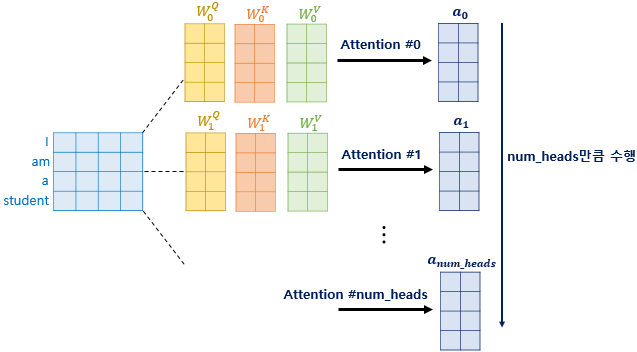

Transformer 저자들의 가정은 하나의 어텐션보다 여러번 어텐션을 나눠서 하는 것이 더 효율적이라고 생각했다. 따라서 $d_{model}$의 차원을 `num_heads`개로 나누어서 $d_{model} / \text{num_heads}$의 차원을 가지는 Q, K, V에 대해서 `num_heads`개의 병렬 어텐션을 수행한다.

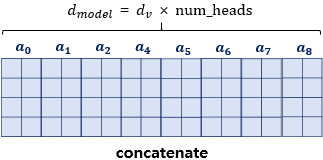

병렬 어텐션을 모두 수행하고 어텐션 헤드를 모두 concat 해 준다. 그 결과 어텐션 헤드 행렬의 크기는 $(\text{seq_len}, d_{model})$이 된다.
최종적인 multi-head attention matrix는 weight matrix $W^0$를 곱한 것이 된다.

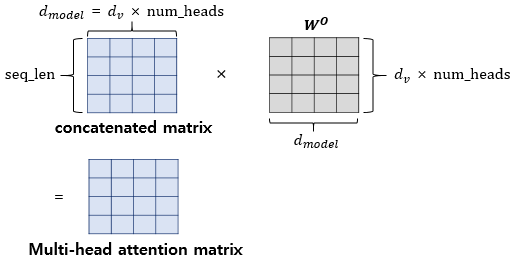

최종적으로 크기는 $(\text{seq_len}, d_{model})$이 된다.
즉, hidden size의 크기가 유지 되는데 이는 여러 레이어를 효과적으로 쌓기 위함이다.

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters
# image size: 28 x 28
sequence_length = 28
input_size = 28

num_layers = 5
hidden_size = 128
num_classes = 10

batch_size = 100
num_epochs = 10
learning_rate = 0.001

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model

In [ ]:
class SelfAtt(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=4, dim_feedforward=hidden_size)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
    self.fc = nn.Linear(input_size, num_classes)
  
  def forward(self, x):
    x = self.transformer_encoder(x)
    # (Seq_len, B, Inputsize)
    x = x.mean(dim=2)
    # (Seq_len, B)
    x = x.permute(1, 0)
    # (B, Seq_len)
    x = self.fc(x)
    return x

In [ ]:
model = SelfAtt(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        # images = images.transpose(0, 1)
        images = images.permute(1, 0, 2)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/600], Loss: 2.1709
Epoch [1/10], Step [200/600], Loss: 1.6388
Epoch [1/10], Step [300/600], Loss: 1.0983
Epoch [1/10], Step [400/600], Loss: 0.8785
Epoch [1/10], Step [500/600], Loss: 0.6770
Epoch [1/10], Step [600/600], Loss: 0.6067
Epoch [2/10], Step [100/600], Loss: 0.3968
Epoch [2/10], Step [200/600], Loss: 0.7399
Epoch [2/10], Step [300/600], Loss: 0.4127
Epoch [2/10], Step [400/600], Loss: 0.3729
Epoch [2/10], Step [500/600], Loss: 0.4688
Epoch [2/10], Step [600/600], Loss: 0.2870
Epoch [3/10], Step [100/600], Loss: 0.3161
Epoch [3/10], Step [200/600], Loss: 0.3601
Epoch [3/10], Step [300/600], Loss: 0.2324
Epoch [3/10], Step [400/600], Loss: 0.4844
Epoch [3/10], Step [500/600], Loss: 0.3515
Epoch [3/10], Step [600/600], Loss: 0.2416
Epoch [4/10], Step [100/600], Loss: 0.3181
Epoch [4/10], Step [200/600], Loss: 0.2867
Epoch [4/10], Step [300/600], Loss: 0.3332
Epoch [4/10], Step [400/600], Loss: 0.2015
Epoch [4/10], Step [500/600], Loss: 0.2242
Epoch [4/10

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        # images = images.transpose(0, 1)
        images = images.permute(1, 0, 2)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 95.15 %


[참고자료](https://wikidocs.net/31379)